In [94]:
import numpy as np
import time
import math
import pandas as pd
from numba import cuda
import cupy
import matplotlib.pyplot as plt

In [95]:
# Вычисление на CPU
def CPU_mat_mul(mat_size):
    cpu_mat1 = np.random.randint(0, 100, (mat_size, mat_size))
    cpu_mat2 = np.random.randint(0, 100, (mat_size, mat_size))  
    start_time = time.time()
    cpu_mat_res = np.dot(cpu_mat1, cpu_mat2)  # Векторное умножение
    res_time = time.time() - start_time
    return res_time

In [96]:
# Векторное перемножение матриц на GPU с помощью CUDA
@cuda.jit
def GPU_mat_mul(A, B, C, mat_size):
    row, col = cuda.grid(2)
    if row < mat_size and col < mat_size:
        res = 0
        for i in range(mat_size):
            res += A[row, i] * B[i, col]
        C[row, col] = res  # Сохраняем результат

# Вычисление на GPU
def GPU_calc(mat_size):
    # Инициализация матриц для GPU
    cpu_mat1 = np.random.randint(0, 100, (mat_size, mat_size))
    cpu_mat2 = np.random.randint(0, 100, (mat_size, mat_size))
    
    gpu_mat1 = cuda.to_device(cpu_mat1)
    gpu_mat2 = cuda.to_device(cpu_mat2)
    gpu_mat_res = cuda.device_array((mat_size, mat_size))

    # Параметры для запуска ядра
    threadsperblock = (32, 32)
    blockspergrid_x = int(np.ceil(mat_size / threadsperblock[0]))
    blockspergrid_y = int(np.ceil(mat_size / threadsperblock[1]))
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    start_time = time.time()
    GPU_mat_mul[blockspergrid, threadsperblock](gpu_mat1, gpu_mat2, gpu_mat_res, mat_size)
    cuda.synchronize() 
    
    res_time = time.time() - start_time
    return res_time

Результаты в зависимости от размера матрицы:
   Размер  Время на CPU  Время на GPU  Ускорение
0     100      0.000000      0.000998   0.000000
1     200      0.002991      0.004985   0.600134
2     400      0.039893      0.037923   1.051936
3     800      0.424865      0.189505   2.241967
4    1200      1.511926      0.506692   2.983916
5    1600     10.252554      0.883652  11.602480


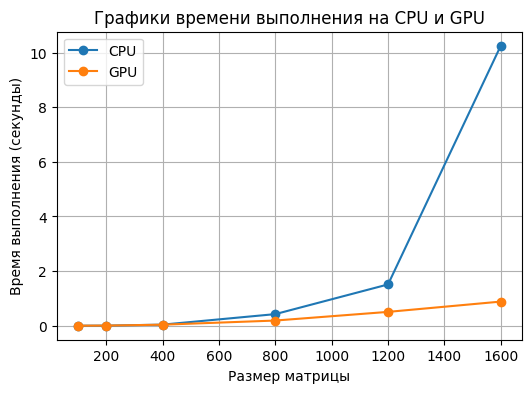

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


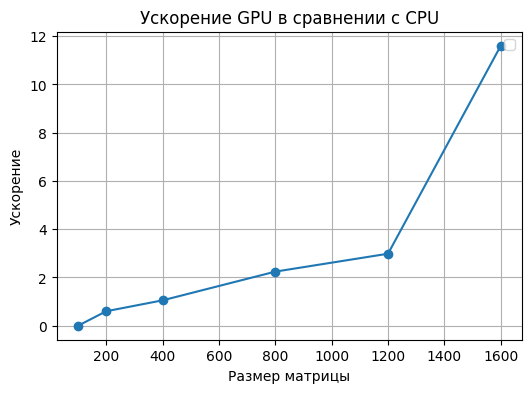

In [97]:
mat_sizes = [100, 200, 400, 800, 1200, 1600]  # Размеры матриц
results = []
for size in mat_sizes:
    #Вычисления на CPU
    cpu_time = CPU_mat_mul(size)

    # GPU вычисления
    gpu_time = gpu_calc(size)

    # Расчет ускорения
    speedup = cpu_time / gpu_time if gpu_time != 0 else float('inf')  
    
    results.append({
        'Размер': size,
        'Время на CPU': cpu_time,
        'Время на GPU': gpu_time,
        'Ускорение': speedup
    })

res_tab = pd.DataFrame(results)
print("Результаты в зависимости от размера матрицы:")
print(res_tab)

# Построение графика времени выполнения
plt.figure(figsize=(6, 4))
plt.plot(mat_sizes, res_tab['Время на CPU'], label="CPU", marker='o')
plt.plot(mat_sizes, res_tab['Время на GPU'], label="GPU", marker='o')
plt.title("Графики времени выполнения на CPU и GPU")
plt.xlabel("Размер матрицы")
plt.ylabel("Время выполнения (секунды)")
plt.legend()
plt.grid(True)
plt.show()

# Построение графика ускорения
plt.figure(figsize=(6, 4))
plt.plot(mat_sizes, res_tab['Ускорение'], marker='o')
plt.title("Ускорение GPU в сравнении с CPU")
plt.xlabel("Размер матрицы")
plt.ylabel("Ускорение")
plt.legend()
plt.grid(True)
plt.show()